# ASTR 211 Spectroscopy Lab (April 20, 2020)

## Names: [Insert your name here]

Today's lab has two parts. 

In Part I, you'll examine CCD data from spectroscopic science and calibration observations. You'll start learning some of the ways in which spectroscopic data reductions are different from imaging data reductions.

In Part II, you'll work with real spectra of a mystery galaxy. You'll determine the galaxy's redshift, measure its emission line fluxes and their FWHM, and decide whether the galaxy's gas is being heated by stars or by an active galactic nucleus (a supermassive black hole). 

Before starting the lab, you should have the following:

(1) ds9 or AstroImageJ installed (https://sites.google.com/cfa.harvard.edu/saoimageds9 or https://www.astro.louisville.edu/software/astroimagej/)

(2) the specutils package for python; 
you can install it via the command line using: conda install -c conda-forge specutils

(3) the three fits images posted on GLOW

[Credit: I've adapted parts of this lab from tutorials by Steve Crawford and the astropy team]

## Part I: Introduction to Spectroscopic CCD Data

Using ds9 or AstroImageJ, open:

(1) masterbias.fits, an example of a Master Bias frame

(2) masterflat.fits, an example of a Master Flat frame

(3) star_spectrum_raw.fits, an example of a raw (unprocessed) stellar spectrum

Adjust the scaling and move your cursor around so you can get a sense of the different count levels in the images. (You'll notice that these particular images are long and narrow. Those are the dimensions of this particular CCD detector, but other spectroscopic detectors could have other dimensions.)

> **Q:** How do these images seem similar to or different from the bias, flat, and science frames we use for imaging observations? 

> **A:** The bias looks similar to the bias for imaging observations. However, the flat field shows a systematic gradient in brightness from top to bottom. The science image shows that the light from the object has been spread out in one direction.

Next, we'll examine some of these data more closely in python.

In [6]:
# Initial imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

# Run the %matplotlib magic command to enable inline plotting
# in the current notebook. 
%matplotlib inline

In [7]:
# read in the master flat
flatname = 'lab/masterflat.fits' #replace "lab" with the directory you downloaded the file to
flat_hdulist = fits.open(flatname)
flat = flat_hdulist[0].data.astype(np.float) #convert the file to an array of floats
flat.shape

(1022, 41)

Above, we've printed the dimensions of the array. You should have 1022 elements in the x-direction and 41 elements in the y-direction. Note that this configuration might be rotated 90 degrees from what you saw in ds9 or AstroImageJ (at least, that's what happened for me!).

The long (x) direction is our "dispersion" direction. Different wavelengths of light fall on different x positions of the detector. The short (y) direction is our "cross-dispersion" direction. Each column of constant x will trace the same wavelength light at different spatial locations. 

Let's look at the overall wavelength behavior of our flat field. To do this, we'll find the mean number of counts at each x position.

In [8]:
fx = flat.sum(axis=1)/flat.shape[1] #sum along the y-direction and divide by the number of y-pixels
xarr = np.arange(len(fx)) #create an array corresponding to x position

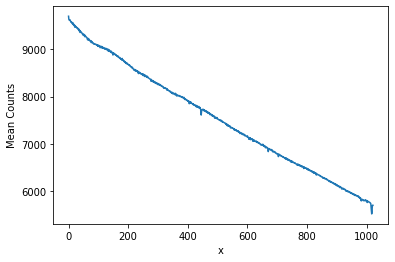

In [9]:
plt.plot(xarr,fx)
plt.xlabel('x')
plt.ylabel('Mean Counts')
plt.show()

Well, that's a weird-looking flat-field! Remember that each x position corresponds to a different wavelength. The quartz lamps we use for flat-fielding are typically ~3000 K, so we've essentially taken a spectrum of a 3000 K blackbody, which peaks in the red.

The goal of a flat-field is to trace pixel-to-pixel variations in CCD sensitivity. For flat-fielding with imaging observations, we normalized our master flat to 1 by dividing the flat-field image by its median.

> **Q:** Why would it be a bad idea to divide our spectroscopic master flat by its median value? What might we do instead?

> **A:** It would be a bad idea, because it wouldn't account for the systematic change in brightness caused by the color of the lamp. We want our flat field to trace variations in the sensitivity of the CCD. The flat field is bright at low x values not because the CCD is more sensitive there but because the lamp is brighter at red wavelengths. If we divide the whole flat field by one single median value, those pixels will still be too bright and the bluer wavelength pixels will be too faint. Instead, we should fit a function to the overall spectral shape of the lamp and divide the flat by that function. All pixels with the same x coordinate will be divided by the same number. 

Here's how we'll proceed...

In [10]:
from astropy import modeling as mod #first, we'll import some fitting routines

> **Q:** The cell below fits a model to our flat field. The goal is to capture the overall spectral shape of the lamp, but we don't need (or want) to capture every small bump and wiggle. 
>
> (a) Modify the order of the fit until you think the fit is satisfactory.
>
> (b) To check your fit, plot the residuals (Fit-Data) as a percent of the original data value. We want to fit our flat-field to a precision of less than 1%. You can ignore the large spike at x>1000, which is just related to hitting the edge of the detector.
>
> (c) Use your fit to normalize our 1D flat-field (that's the array named fx). Plot the normalized fx vs. xarr and check that it has values hovering around 1. (Note that in reality, we'd want to normalize the 2D flat field array named "flat", but here we're just checking how well we did the fitting).

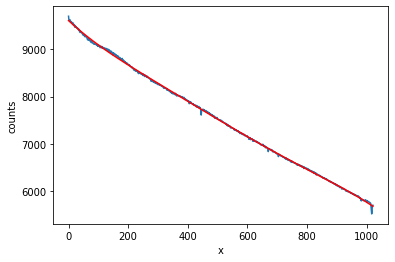

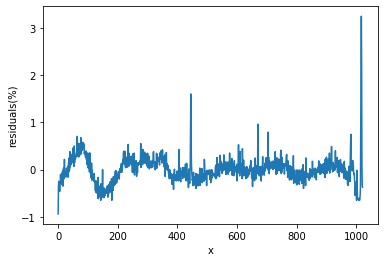

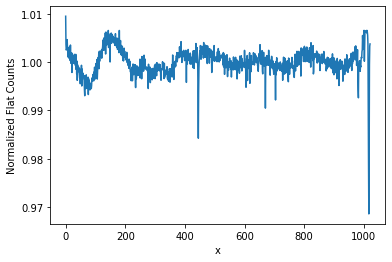

In [11]:
# next, we'll fit a function to capture the overall spectral shape of the lamp.
# We call this fit the "response function"
cheb = mod.models.Chebyshev1D(5) #this generates a Chebyshev function of order 1.
#Higher orders have more free parameters and can fit more complex shapes
fitter = mod.fitting.LinearLSQFitter()
resp_func = fitter(cheb, xarr, fx)

plt.plot(xarr,fx) #plots our original flat field
plt.plot(xarr,resp_func(xarr),'r') #plots our modeled response function
plt.xlabel('x')
plt.ylabel('counts')
plt.show()

#insert plot of residuals here. be sure to label axes!
plt.plot(xarr,(resp_func(xarr)-fx)/fx*100)
plt.xlabel('x')
plt.ylabel('residuals(%)')
plt.show()

#insert plot of normalized flat here
plt.plot(xarr,fx/resp_func(xarr))
plt.xlabel('x')
plt.ylabel('Normalized Flat Counts')
plt.show()

Now, let's take a look at some reduced spectral data. We'll read in the image star_spectrum_proc.fits, which has been bias-subtracted and divided by a normalized flat field. 

In [12]:
#read in the file
starname = 'lab/star_spectrum_proc.fits' #replace "lab" with the directory you downloaded the file to
star_hdulist = fits.open(starname)
star = star_hdulist[0].data.astype(np.float) #convert the file to an array of floats


Here's what the data look like on average along the x-direction (the equivalent of what we did before for the flat field).

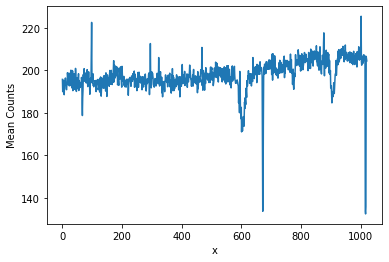

In [13]:
fx = star.sum(axis=1)/star.shape[1] #sum along the y-direction and divide by the number of y-pixels
xarr = np.arange(len(fx)) #create an array corresponding to x position
plt.plot(xarr,fx)
plt.xlabel('x')
plt.ylabel('Mean Counts')
plt.show()

You can see some overall continuum emission, plus several absorption lines. Now, let's also look at the shape of our data along the y-direction. Here, we'll just take a slice at one particular x value. 

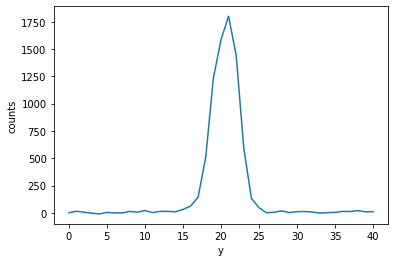

In [14]:
yarr=np.arange(star.shape[1]) #make an array of y-values
plt.plot(yarr,star[1,0:len(yarr)]) #plot x=1 at all y-values
plt.xlabel('y')
plt.ylabel('counts')
plt.show()

In the plot above, you can see that our targeted star covers ~10 pixels, from y=15 to y=25. What about the other pixels (y<15 and y>25)?

> **Q:** In the next cell, use the matplotlib ylim command to change the y-axis limits to create a zoomed in version of the plot above, so that you can see the counts in the pixels that *don't* correspond to the central star.

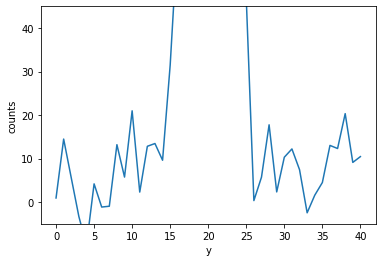

In [15]:
plt.plot(yarr,star[1,0:len(yarr)])
#plt.ylim(min,max) #uncomment this and put in your desired limits for min and max.
plt.ylim(-5,45)
plt.xlabel('y')
plt.ylabel('counts')
plt.show()

> **Q:** What would you (by eye) estimate as the average number of counts in the off-source region? Where do these counts come from?

> **A:** There seem to be ~7 counts per pixel in the background region. These counts come from sky emission.

Just as with aperture photometry, we need to subtract this background level of counts from our spectrum. In the cell below, we'll measure the mean counts in this background region at each wavelength position x and subtract it from our data.

> **Q:** Edit the cell below so that none of the source pixels are included in the "sky" region. 

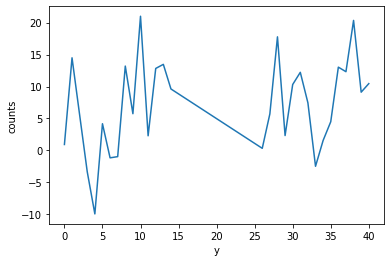

In [16]:
sky=np.delete(star,np.s_[15:26],1) #deletes the specified pixel columns.
yarr2=np.delete(yarr,np.s_[15:26])

plt.plot(yarr2,sky[1,0:len(yarr2)])
plt.xlabel('y')
plt.ylabel('counts')
plt.show() #you'll notice the missing pixels are connected by a straight line.

bkg=sky.mean(axis=1) #measures the mean of the sky region at each x
bkgsub=star-bkg.reshape((len(bkg),1)) 
#creates a 2D array where the mean at each x is duplicated at every y
#and subtracts it from our star's spectrum.



> **Q:** Let's see how that worked. Copy and edit the plotting code from one of the preceding cells to create a zoomed in plot of the background-subtracted spectrum (bkgsub). Is the mean in the background now near 0?

>**A:** Yes.

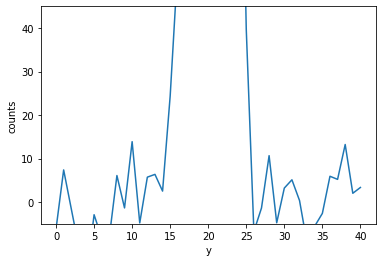

In [18]:
plt.plot(yarr,bkgsub[1,0:len(yarr)])
plt.ylim(-5,45)
plt.xlabel('y')
plt.ylabel('counts')
plt.show()

Our next step is to "extract" our spectrum, to sum the counts that correspond to our star and exclude the background at each x value.

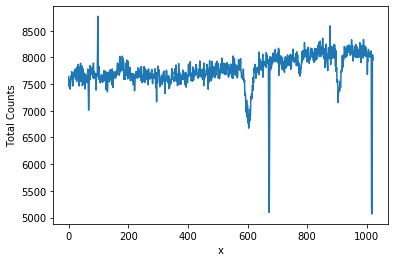

In [19]:
staronly0=np.delete(bkgsub,np.s_[0:14],1) #cuts off the left side background
staronly=np.delete(staronly0,np.s_[11:27],1) #cuts off the right side background

fx2 = staronly.sum(axis=1) #let's sum up the counts at each x position
plt.plot(xarr,fx2) #and plot our new, background-subtracted spectrum
plt.xlabel('x')
plt.ylabel('Total Counts')
plt.show()

## Part II: Analyzing Spectra

Now, we'll explore some of the measurements we can make with spectra, using a galaxy spectrum from the Sloan Digital Sky Survey. You will find this galaxy's redshift and decide whether an active galactic nucleus (supermassive black hole) or young stars are lighting up the gas in this mystery galaxy.

In [21]:
#importing necessary packages
import astropy.units as u
import astropy
import numpy as np
import matplotlib as mp

import specutils
from specutils import Spectrum1D, SpectralRegion
from astropy.nddata import StdDevUncertainty
from astropy.visualization import quantity_support
quantity_support();

print('Astropy version',astropy.__version__)
print('Specutils version',specutils.__version__)
print('Numpy version',np.__version__)
print('Matplotlib version',mp.__version__)

Astropy version 4.0
Specutils version 1.0
Numpy version 1.18.1
Matplotlib version 3.1.3


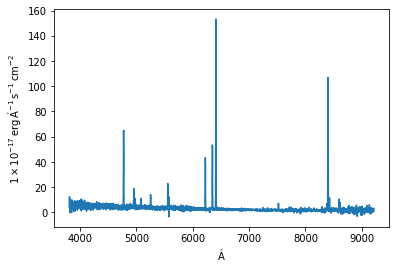

In [22]:
#read in and display the spectrum
#edit the directory as needed
sdss_spec = Spectrum1D.read('lab/sdss_spectrum.fits', format='SDSS-III/IV spec')
plt.step(sdss_spec.wavelength, sdss_spec.flux)
#note that wavelengths are stored in spectrum_name.wavelength 
#and fluxes are stored in spectrum_name.flux


Our galaxy has faint continuous emission with bright emission lines. The bright emission lines come from particular elements in ionized gas. The brightest lines are from hydrogen and oxygen.

> **Q:** Instead of flux, let's consider the signal-to-noise ratio in our spectrum. Modify the cell below to plot S/N as a function of wavelength. Compare your S/N plot with the plot of the spectrum above. Which wavelength regions have the highest S/N?

>**A:** The emission lines have the highest S/N.

Text(0, 0.5, 'S/N')

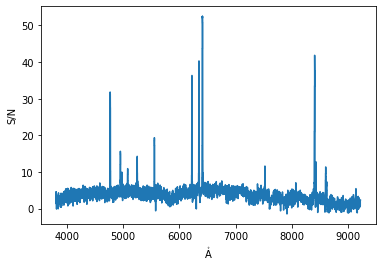

In [23]:
#The spectra read in by specutils have associated units
#Here, we'll isolate just the flux value and remove its units
#We're also taking just the uncertainty value, so that specutils 
#doesn't try to do any sort of error propagation with it.
flux=sdss_spec.flux.value
error = sdss_spec.uncertainty.array
snr=flux/error
plt.step(sdss_spec.wavelength,snr)
plt.ylabel('S/N')

Now, we're going to find the redshift of our galaxy. Each emission line in our galaxy's spectrum has experienced a Doppler shift due to the expansion of the universe. The more distant a galaxy is, the more its light has been stretched to longer wavelengths. We often use "redshift" as a measure of how far away a galaxy is. Redshift z is defined as 
\begin{align}
z=\frac{\Delta \lambda}{\lambda_0}
\end{align}
or equivalently,
\begin{align}
\lambda' = \lambda_0*(1+z)
\end{align}
where $\lambda_0$ is the original wavelength of light emitted and $\lambda'$ is the wavelength of light we observe.

The strongest emission line in our spectrum is an [O III] line, which is emitted at a "rest-frame" (original) wavelength of 5008.239 Angstroms. ("[O III]" means the line is from doubly ionized oxygen). 
> **Q:** Write code in the cell below to find the observed wavelength of the [O III] line and calculate and print the redshift of our galaxy. Some potentially useful commands: "max(array)" gives you the maximum value of an array. "np.argmax(array)" gives you the array index at which the maximum value appears. For instance, in the array "test_array = [5,3,2,6,1]", max(test_array) = 6 and np.argmax(test_array)=3. 

In [24]:
#Note that because specutils spectra have units
#you may need to add or remove units in your calculations here.
# to remove units from a quantity, use ".value"
# so sdss_spectrum.flux has flux units, but sdss_spectrum.flux.value is unitless
# to add units, multiply by u.unitname. "u.AA" adds units of Angstroms. So, mywave=4000*u.AA
# creates a wavelength of 4000 Angstroms.

o3index=np.argmax(sdss_spec.flux)
o3wave=sdss_spec.wavelength[o3index]
redshift=o3wave/(5008.239*u.AA)-1
print(redshift)


0.28001471752970475


You should find a redshift of z=0.28. If you didn't, double-check your code.
Now, if we want, we can correct all our observed wavelengths to the wavelengths emitted in the rest-frame of our galaxy. This correction makes it easier to identify spectral features.
> **Q:** In the cell below, create an array of rest-frame wavelengths ($\lambda_0$), using the observed wavelengths and the galaxy redshift. Make a new plot with rest-frame wavelength on the x-axis and flux on the y-axis.

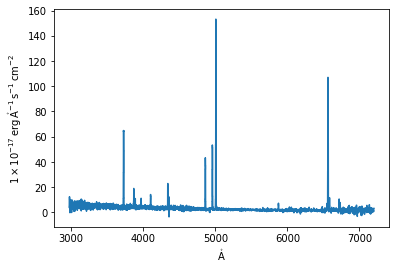

In [25]:
restwave=sdss_spec.wavelength/(1+redshift)
plt.step(restwave,sdss_spec.flux)

You should see that the strongest emission line is now right at 5008 Angstroms, where it was originally emitted. 

Let's zoom into the [O III] region of our spectrum to analyze the lines there in more detail. Obviously, one way to zoom in would be to simply change our plotted axis range. However, we might also want to do some computations that involve only that subset of our spectral array. In the specutils package, we can use "extract_region" to select subsections of our spectrum.

In [26]:
from specutils.manipulation import extract_region
#imports the relevant tools

In [27]:
#here, we'll zoom into the region surrounding the [O III] line.
#the u.AA command means units of Angstroms
o3region = SpectralRegion((6000)*u.AA, (6500)*u.AA) #defines our subregion
o3subspec = extract_region(sdss_spec, o3region) #extracts our subspectrum

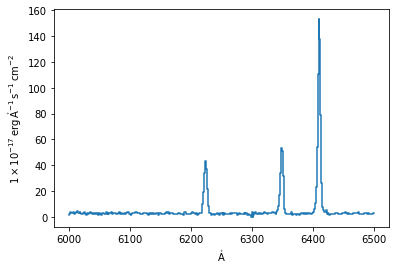

(0, 7.5)

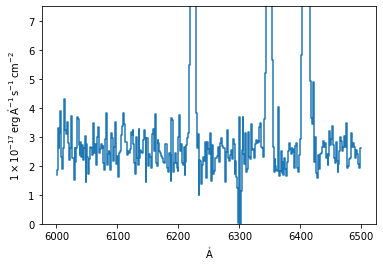

In [28]:
#let's plot our subregion
plt.step(o3subspec.wavelength,o3subspec.flux)
plt.show()
#and plot it again, but this time zoomed in to see the continuum level
plt.step(o3subspec.wavelength,o3subspec.flux)
plt.ylim(0,7.5)

The figure above shows that the galaxy has continuum emission (mostly produced by stars in the galaxy) at all wavelengths, whereas the emission lines have flux only at particular wavelengths.

To measure the flux of a source using aperture photometry, we subtract off the sky background. To measure the flux from a single object's spectrum, we subtract off the background sky spectrum, as we did in Part I of this lab.
Likewise, to measure the flux of a single emission line in a spectrum, we have to subtract off the continuum level, so that we isolate only the flux coming from that emission line.

The [O III] line is the strong line at ~6400 Ang. There are two other prominent, but weaker, emission lines to the left of the [O III] line. They are another [O III] line at rest-frame 4960 Ang (observed at ~6350 Ang) and the Hydrogen Balmer H$\beta$ line at rest-frame 4863 Ang (observed at ~6200 Ang). 

> **Q:** In the cell below, write code to measure the mean flux for a continuum region near the [O III] line. You'll first want to create a subspectrum containing only the continuum wavelengths you want. Then, use np.mean to measure the mean flux in that region.

In [29]:
cont_region = SpectralRegion((6100)*u.AA, (6200)*u.AA)
contspec = extract_region(sdss_spec, cont_region)
cont_level=np.mean(contspec.flux)
cont_level

<Quantity 2.5561512 1e-17 erg / (Angstrom cm2 s)>

> **Q:** Now, create a new array of fluxes for the [O III] region, called "o3_contsub" by subtracting your continuum level from the [O III] subregion fluxes.

In [30]:
o3_contsub=o3subspec-cont_level
#if you get a warning, ignore it.


/Users/08aej/anaconda3/envs/astroconda/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2537: RuntimeWarning: invalid value encountered in true_divide
  (grid[i + 1] - grid[i]))


Great! Now that our continuum has been subtracted, we can move on to measuring the fluxes of our emission lines. We will do this by fitting a Gaussian function to our emission lines and integrating that Gaussian function over wavelength.

In [31]:
#First, let's get some fitting tools.

from specutils import fitting
from astropy.modeling import models


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning.


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
6224.4365234375,emission,159
6348.9228515625,emission,245
6410.61962890625,emission,287


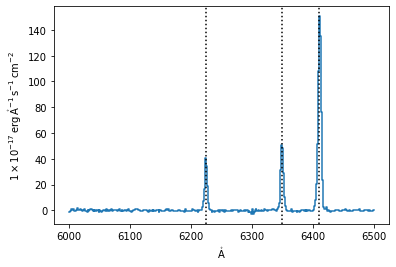

In [32]:
#this command finds all emission lines with S/N > 5
o3_lines = fitting.find_lines_threshold(o3_contsub, 5)

#and plots them
plt.step(o3_contsub.spectral_axis, o3_contsub.flux, where='mid')
for line in o3_lines:
    plt.axvline(line['line_center'], color='k', ls=':')

#and lists their center wavelengths
o3_lines
#ignore the warning here too.

> **Q:** The code below fits a Gaussian to each of the 3 spectral lines in our [O III] region. Figure out what each step in the cell below does and add a comment to each line describing what it's doing. One line is already commented. It fixes a random specutils bug and you don't need to understand what it does. 

[<QuantityModel Gaussian1D(amplitude=40.55997146, mean=6224.53404089, stddev=2.23188591), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>,
 <QuantityModel Gaussian1D(amplitude=52.33321861, mean=6349.52942705, stddev=2.13957242), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>,
 <QuantityModel Gaussian1D(amplitude=152.61286483, mean=6410.93998503, stddev=2.22094413), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>]

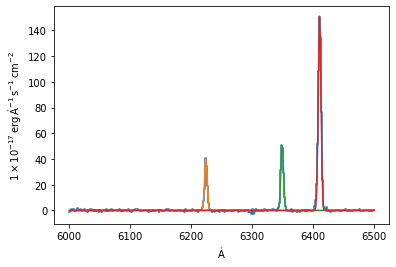

In [33]:
o3_line_models = [] #Set up an array of model fits
for line in o3_lines: #For each line found
    line_region = SpectralRegion(line['line_center']-5*u.angstrom,
                                 line['line_center']+5*u.angstrom) #Define a spectral region
    #within 5 Ang of the line
    line_spectrum = extract_region(o3_contsub, line_region) #Extract that subregion
    # the line below fixes a bug. it's necessary according to the specutils folks.
    line_spectrum = Spectrum1D(flux=line_spectrum.flux, spectral_axis=line_spectrum.spectral_axis, uncertainty=line_spectrum.uncertainty)
    line_estimate = models.Gaussian1D(mean=line['line_center']) #Define a Gaussian model centered
    #at the line center wavelength
    line_model = fitting.fit_lines(line_spectrum, line_estimate) #Fit the subspectrum 
    #with the Gaussian model
    
    o3_line_models.append(line_model) #Add the model fit to the model fit array
    
plt.step(o3_contsub.spectral_axis, o3_contsub.flux, where='mid') #Plot the spectrum
for line_model in o3_line_models: #For each line we fit
    evaluated_model = line_model(o3_contsub.spectral_axis) #Derive y-values (fluxes) using our
    #best fit model and the input x (wavelength) array.
    plt.plot(o3_contsub.spectral_axis, evaluated_model)   #Plot the model fits.
    
o3_line_models #Print the model parameters

A generic Gaussian function is: 
\begin{align}
\large
f(x) = a e^{\frac{-(x-b)^2}{2c^2}}
\end{align}
In our line-fitting example, f(x) = flux and x = wavelength. In the line fit outputs, a = amplitude, b = mean, and c = stddev.

The FWHM of a Gaussian is:
\begin{align}
FWHM = 2c\sqrt{2 \ln 2}
\end{align}

and the integral of a Gaussian is:
\begin{align}
\int_{-\infty }^{\infty }f(x)dx = a\left | c \right |\sqrt{2\pi}
\end{align}
To find "a" for the shortest wavelength line (H$\beta$), you would type o3_line_models[0].amplitude. For [O III] 5008, it would be: o3_line_models[2].amplitude.

> **Q:** In the cell below, write code to calculate the FWHM of the H$\beta$ line in Angstroms and in km/s. (For velocity units, $\frac{\Delta \lambda}{\lambda} = \frac{v}{c}$, where $\lambda$ is the central wavelength and c is the speed of light.) numpy has commands for ln and square root.

(Note that since we fit the Gaussian profile to our observed wavelengths, $\lambda$ in the velocity equation also needs to be an observed wavelength. If we had fit the Gaussian to the rest-frame wavelengths, $\lambda$ would be a rest-frame wavelength).

In [34]:
hb_fwhm=2.0*np.sqrt(2.0*np.log(2.0))*o3_line_models[0].stddev
print(hb_fwhm) #in Ang
hb_vel=hb_fwhm/o3_line_models[0].mean*3*10**5
hb_vel #in km/s

5.255689673229595


253.3052099341527

> **Q:** In the cell below, write code to find the total line fluxes of the H$\beta$ and [O III] 5008 lines by integrating their Gaussian fits over wavelength. Hint: you don't actually have to do an integral in python. Just use the formula for the integral of a Gaussian.

In [36]:
hb_flux=o3_line_models[0].amplitude*o3_line_models[0].return_units*o3_line_models[0].stddev*u.AA*np.sqrt(2.0*np.pi)
o3_flux=o3_line_models[2].amplitude*o3_line_models[2].return_units*o3_line_models[2].stddev*u.AA*np.sqrt(2.0*np.pi)
print(hb_flux)
print(o3_flux)

226.91309784726477 1e-17 erg / (cm2 s)
849.6082333414304 1e-17 erg / (cm2 s)


Almost done! We need to measure the fluxes of two other spectral lines, the Hydrogen Balmer H$\alpha$ line and its neighboring [N II] (singly-ionized nitrogen) line at rest-frame wavelength 6585 Ang. We'll do the exact same steps as before.

(0, 7.5)

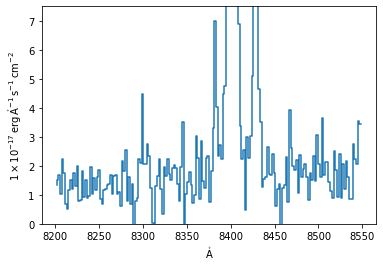

In [37]:
#Define the spectral region around H-alpha. 
#H-alpha is the strong line at the red end of our spectrum

ha_region = SpectralRegion((8200)*u.AA, (8550)*u.AA)
hasubspec = extract_region(sdss_spec, ha_region)
plt.step(hasubspec.wavelength,hasubspec.flux)
plt.ylim(0,7.5) #a zoomed in plot to see the continuum level


> **Q:** Copy your code from above to estimate the continuum level near H$\alpha$. Extract a continuum region between 8450 and 8525 Ang, and measure and store the mean flux as a variable called hacont_level.

In [38]:
hacont_region = SpectralRegion((8450)*u.AA, (8525)*u.AA)
hacontspec = extract_region(sdss_spec, hacont_region)
hacont_level=np.mean(hacontspec.flux)
hacont_level

<Quantity 1.7383878 1e-17 erg / (Angstrom cm2 s)>

In [39]:
#Now we create a continuum-subtracted H-alpha region
#ignore any warnings
ha_contsub = extract_region(sdss_spec, ha_region) - hacont_level

/Users/08aej/anaconda3/envs/astroconda/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:2537: RuntimeWarning: invalid value encountered in true_divide
  (grid[i + 1] - grid[i]))


/Users/08aej/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/08aej/anaconda3/envs/astroconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]

If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning.


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
8402.3369140625,emission,105
8429.466796875,emission,119


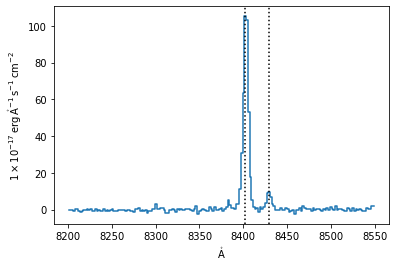

In [40]:
#and we fit to find line centers
ha_lines = fitting.find_lines_threshold(ha_contsub, 5)

plt.step(ha_contsub.spectral_axis, ha_contsub.flux, where='mid')
for line in ha_lines:
    plt.axvline(line['line_center'], color='k', ls=':')

ha_lines

[<QuantityModel Gaussian1D(amplitude=110.00714194, mean=8403.07364247, stddev=2.6937161), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>,
 <QuantityModel Gaussian1D(amplitude=10.19413613, mean=8429.10778644, stddev=2.53961795), input_units=Angstrom, return_units=1e-17 erg / (Angstrom cm2 s)>]

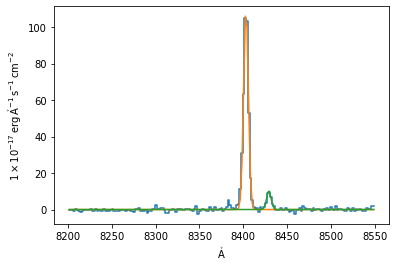

In [41]:
#and run the same Gaussian model fits. This is the exact same code as before. 
#I've just replaced "o3" with "ha"
ha_line_models = []
for line in ha_lines:
    line_region = SpectralRegion(line['line_center']-5*u.angstrom,
                                 line['line_center']+5*u.angstrom)
    line_spectrum = extract_region(ha_contsub, line_region)
    # here's the workaround from above again
    line_spectrum = Spectrum1D(flux=line_spectrum.flux, spectral_axis=line_spectrum.spectral_axis, uncertainty=line_spectrum.uncertainty)
    line_estimate = models.Gaussian1D(mean=line['line_center'])
    line_model = fitting.fit_lines(line_spectrum, line_estimate)
    
    ha_line_models.append(line_model)
    
plt.step(ha_contsub.spectral_axis, ha_contsub.flux, where='mid')
for line_model in ha_line_models:
    evaluated_model = line_model(ha_contsub.spectral_axis)
    plt.plot(ha_contsub.spectral_axis, evaluated_model)  
    
ha_line_models

> **Q:** Copy your code from above to calculate the total integrated flux in the H-alpha line (the strong line) and in the [N II] line (the weaker line). 

In [42]:
ha_flux=ha_line_models[0].amplitude*ha_line_models[0].return_units*ha_line_models[0].stddev*u.AA*np.sqrt(2.0*np.pi)
n2_flux=ha_line_models[1].amplitude*ha_line_models[1].return_units*ha_line_models[1].stddev*u.AA*np.sqrt(2.0*np.pi)
ha_flux, n2_flux

(<Quantity 742.78416776 1e-17 erg / (cm2 s)>,
 <Quantity 64.89462858 1e-17 erg / (cm2 s)>)

The Grand Finale!

Active galactic nuclei (AGN) emit photons at higher energies than stars do. As a result, they heat gas to higher temperatures and particles within that gas move faster. The [O III] and [N II] lines are emitted when electrons collide with O++ and N+ atoms and give energy to those atoms, thereby exciting one of the atoms' electrons into an upper energy state. When the electron falls back down to a lower energy level, it emits the light at the emission line wavelength we observe.

What this means is that gas around AGN has stronger [N II] 6585 and [O III] 5008 emission than the gas around stars. 

According to predictions for AGN, gas around an AGN should have:
\begin{align}
\log([O III]/H\beta) > \frac{0.61}{\log([N II]/H\alpha)-0.05}+1.3
\end{align}

I've plotted this line in the figure below.

> **Q:** Use your measured [O III] 5008, H$\beta$, [N II] 6585, and H$\alpha$ fluxes to calculate log([O III]/H$\beta$) and log([N II]/H$\alpha$). Be sure to use the base 10 log in numpy. Plot your data point on the figure below. If your data point is above the line, the mystery galaxy is an AGN. If it's below the line, it's a star-forming galaxy. Which is it?

> **A:** It's a star-forming galaxy.

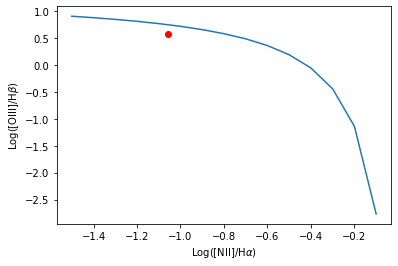

In [44]:
from matplotlib import rc #lets us use Greek letters in our plotting
o3hb=np.log10(o3_flux/hb_flux)
n2ha=np.log10(n2_flux/ha_flux)
n2ha_arr=np.arange(-1.5,0,0.1) #creating an array for plotting
o3hb_arr=0.61/(n2ha_arr-0.05)+1.3 #the equation separating AGN and star-forming galaxies
plt.plot(n2ha_arr, o3hb_arr)
plt.plot(n2ha,o3hb,'ro') #plotting your data point
plt.xlabel(r'Log([NII]/H$\alpha$)')
plt.ylabel(r'Log([OIII]/H$\beta$)')
plt.show()

You did it! Email this jupyter notebook to Prof. Jaskot (08aej@williams.edu).
(Prof. Jaskot is leading the spectroscopy unit, so this lab actually goes to her and not Dr. Flaherty).
